In [1]:
import numpy as np
import pickle
import cv2
import os
import tensorflow
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
epochs = 25
initial_learning_rate = 1e-3
batch_size = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/My Drive/ML Plant Dataset/plantdisease_dataset'
width=256
height=256
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
listdir(directory_root)

['PlantVillage']

In [6]:
image_list, label_list = [], []
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing {plant_disease_folder}")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
           
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Loading images ...
Processing Tomato_Late_blight
Processing Pepper__bell___healthy
Processing Pepper__bell___Bacterial_spot
Processing Potato___Late_blight
Processing Tomato_Leaf_Mold
Processing Tomato_Spider_mites_Two_spotted_spider_mite
Processing Tomato__Tomato_mosaic_virus
Processing Tomato_Septoria_leaf_spot
Processing Tomato_Bacterial_spot
Processing Potato___healthy
Processing Tomato__Target_Spot
Processing Tomato_healthy
Processing Potato___Early_blight
Processing Tomato_Early_blight
Processing Tomato__Tomato_YellowLeaf__Curl_Virus
Image loading completed


In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('/content/drive/My Drive/ML Plant Dataset/labeltransform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
n_classes

15

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
numpy_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
x_train, x_test, y_train, y_test = train_test_split(numpy_image_list, image_labels, test_size=0.2, random_state = 42) 

In [11]:
augmentation = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [14]:
model_optimizer = Adam(learning_rate=initial_learning_rate, decay=initial_learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=model_optimizer,metrics=["accuracy"])

In [15]:

history = model.fit_generator(
    augmentation.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs, 
    verbose=1
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/25
73/73 [==============================] - 557s 8s/step - loss: 0.6140 - accuracy: 0.2370 - val_loss: 0.3187 - val_accuracy: 0.1218
Epoch 2/25
73/73 [==============================] - 548s 7s/step - loss: 0.2848 - accuracy: 0.3186 - val_loss: 0.6115 - val_accuracy: 0.0914
Epoch 3/25
73/73 [==============================] - 532s 7s/step - loss: 0.2291 - accuracy: 0.4032 - val_loss: 0.5075 - val_accuracy: 0.0626
Epoch 4/25
73/73 [==============================] - 516s 7s/step - loss: 0.1847 - accuracy: 0.5165 - val_loss: 0.4702 - val_accuracy: 0.1184
Epoch 5/25
73/73 [==============================] - 512s 7s/step - loss: 0.1561 - accuracy: 0.6161 - val_loss: 0.7311 - val_accuracy: 0.1083
Epoch 6/25
73/73 [==============================] - 515s 7s/step - loss: 0.1409 - accuracy: 0.6548 - val_loss: 0.3341 - val_accuracy: 0.2640
Epoch 7/25
73/73 [==============================] - 521s 7s/step - loss: 0.1242 - accuracy: 0.7012 - val_loss: 0.1917 - val_accuracy: 0.4839
Epoch 8/25
73

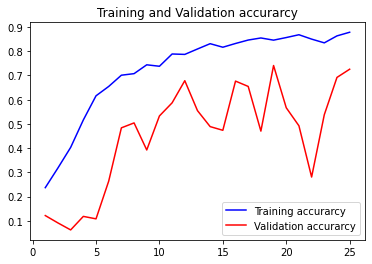

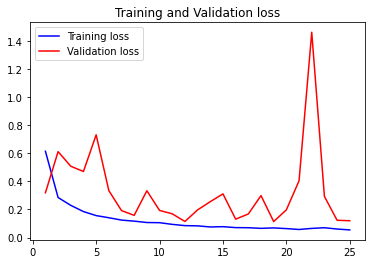

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [17]:
print("Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
19/19 [==============================] - 29s 2s/step - loss: 0.1195 - accuracy: 0.7259
Test Accuracy: 72.58883118629456


In [19]:
# save the model to disk
print("Saving model...")
pickle.dump(model,open('/content/drive/My Drive/ML Plant Dataset/cnnmodel.pkl', 'wb'))

Saving model...
INFO:tensorflow:Assets written to: ram://c0000217-b404-4f89-a1dd-a61ee6465377/assets


In [20]:
loaded_model = pickle.load(open('/content/drive/My Drive/ML Plant Dataset/cnnmodel.pkl', 'rb'))

In [21]:
model_disease=loaded_model

In [22]:
image_dir="/content/drive/My Drive/ML Plant Dataset/predict/1.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)


In [23]:
result=model_disease.predict(npp_image)
print(result)

[[1.6340882e-01 1.2132198e-04 3.7753858e-04 7.9603839e-01 5.4208818e-04
  7.2089181e-04 1.0431036e-02 1.9556694e-03 1.8295511e-03 1.8079327e-02
  8.8236097e-04 5.5091791e-03 8.8629604e-05 5.8022447e-06 9.3499411e-06]]


In [24]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.7960384
Potato___Late_blight
